# Определение перспективного тарифа для телеком-компании

Предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.


## Изучение данных из файлов и их предобработка

In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as st
import math
import matplotlib.pyplot as plt

In [2]:
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

In [3]:
for data in [calls, internet, messages, users, tariffs]: print(data.info(), end='\n\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None

<class 'pandas.core.fram

**Вывод**

Таблица users

Видим пропуски только в 'churn_date', это означает, что человек еще пользуется тарифом
reg_date необходимо изменить тип данных на дату

tariff переименовать в tariff_name (по подобию в таблице tarrifs)

Таблица calls

call_date необходимо изменить тип данных на дату

Таблица messages

message_date необходимо изменить тип данных на дату

Таблица internet

session_date необходимо изменить тип данных на дату

удалить столбец 'Unnamed: 0' который полностью дублирует индекс
Таблица tariffs

Ничего не делаем, данные в таблице корректны

Таблицы будем связывать по ключам:

Первые четыре по ключу 'user_id'

Последнюю по ключу 'tariffs_name'

In [4]:
# Переименование столбцов
users.rename(columns={"tariff": "tariff_name"}, inplace = True)

In [5]:
# Удаление столбцов
internet.drop(['Unnamed: 0'], axis=1, inplace = True)

In [6]:
# Обработка пропусков
users['churn_date'].fillna(value = '2018-12-01',inplace = True)

In [7]:
# Изменение типов данных
users = users.assign(
    reg_date = lambda x: pd.to_datetime(x.reg_date, format='%Y-%m-%dT%H:%M:%S'),
    reg_month = lambda x: x.reg_date.values.astype('datetime64[M]'),
    churn_date = lambda x: pd.to_datetime(x.churn_date, format='%Y-%m-%dT%H:%M:%S'),
    churn_month = lambda x: x.churn_date.values.astype('datetime64[M]'),
    escape = np.where(users.churn_date != '2018-12-01', 1, 0)
)

calls = calls.assign(
    call_date = lambda x: pd.to_datetime(x.call_date, format='%Y-%m-%dT%H:%M:%S'),
    month = lambda x: x.call_date.values.astype('datetime64[M]')
)

messages = messages.assign(
    message_date = lambda x: pd.to_datetime(x.message_date, format='%Y-%m-%dT%H:%M:%S'),
    month = lambda x: x.message_date.values.astype('datetime64[M]')
)

internet = internet.assign(
    session_date = lambda x: pd.to_datetime(x.session_date, format='%Y-%m-%dT%H:%M:%S'),
    month = lambda x: x.session_date.values.astype('datetime64[M]')
)

In [8]:
# Изменение типов данных
print('Итого дубликатов:',(users.duplicated().sum()) +
      calls.duplicated().sum() + 
      messages.duplicated().sum() + 
      internet.duplicated().sum() + 
      tariffs.duplicated().sum())

Итого дубликатов: 0


**Вывод**

переименовали tariff в tariff_name для простоты объеденения таблиц в последующих действиях

изменили тип данных во всех столбцах с датой

добавили столбец с месяцем для всех таблиц

проверили таблицы на наличие дубликатов

удалили ошибочный столбец в таблице 'internet'

категоризацию данных проыведем позже по городам

заполнили пропуски в churn_date на последние месяцы

## Анализ пользователей

In [9]:
print('Количество пропущенных звонков:',calls[calls['duration'] == 0]['id'].count())

Количество пропущенных звонков: 39613


Так как звонков продолжительностью 0 сек слишком много, посмотрим, как не состояшиеся вызовы повлияли на результаты анализа.

добавим столбец с ихрасходованными минутами (округлим продолжительность звонка вверх, до целых)

добавим столбец с количеством всех вызовов (будем использовать для сравнения)

Добавим столбец со значением True, если звонок состоялся (длился дольше 0.00 минуты)

А также добавим столбцы со средними продолжительностями всех и только сосотоявшихся звонков (будем использовать для сравнения)


In [10]:
calls = calls.assign(
    duration_fact = lambda x: x.duration.apply(np.ceil).astype(int),
    call_all = 1,
    call_fact = lambda x: (x.duration != 0.00) *1,
    call_all_avg = lambda x: x.duration_fact / x.call_all,
    call_fact_avg = lambda x: x.duration_fact /x.call_fact   
    )

In [11]:
# Посчитаем средний расход минут для всех звонков и только для состоявшихся
all = calls.duration_fact.sum() / calls.call_all.sum()
fact = calls.duration_fact.sum() / calls.call_fact.sum()

print('Средний расход минут для всех вызовов: {:.2f}'.format(all),'мин')
print('Средний расход минут для состоявшихся звонков: {:.2f}'.format(fact),'мин')
print('Средний расход минут отличается на: {:.2%}'.format(fact/all-1))

Средний расход минут для всех вызовов: 7.16 мин
Средний расход минут для состоявшихся звонков: 8.90 мин
Средний расход минут отличается на: 24.30%


In [12]:
# Создадим сгруппированную по месяца и абонентам таблицу
calls_grouped = calls.pivot_table(index = ['user_id','month'], values = ['duration_fact','call_fact'],
                  aggfunc= sum).reset_index()

In [13]:
# Создадим сгруппированную по месяца и абонентам таблицу
messages_grouped = messages.pivot_table(index = ['user_id','month'], values = ['id'],
                  aggfunc= len).rename(columns={"id": "messages_fact"}).reset_index()

In [14]:
# Посмотрим на количество "пустых" сессий:
print('Количество пустых сессий:',internet[internet['mb_used'] == 0]['id'].count())

Количество пустых сессий: 19598


In [15]:
internet = internet.assign(
    mb_used_fact = lambda x: x.mb_used.apply(np.ceil).astype(int),
    session_all = 1,
    session_fact = lambda x: (x.mb_used != 0.00) *1,
    session_all_avg = lambda x: x.mb_used_fact / x.session_all,
    session_fact_avg = lambda x: x.mb_used_fact /x.session_fact   
    )

In [16]:
all = internet.mb_used_fact.sum() / internet.session_all.sum()
fact = internet.mb_used_fact.sum() / internet.session_fact.sum()

print('Средний расход МБ для всех сессий: {:.2f}'.format(all),'МБ')
print('Средний расход МБ для состоявшихся сессий: {:.2f}'.format(fact),'МБ')
print('Средний расход МБ отличается на: {:.2%}'.format(fact/all-1))

Средний расход МБ для всех сессий: 370.62 МБ
Средний расход МБ для состоявшихся сессий: 426.58 МБ
Средний расход МБ отличается на: 15.10%


In [17]:
# Создадим сгруппированную по месяца и абонентам таблицу
internet_grouped = internet.pivot_table(index = ['user_id','month'], values = ['mb_used_fact','session_fact'],
                  aggfunc= sum).reset_index()

**Помесячная выручка с каждого пользователя**

In [18]:
min_month = calls['call_date'].values.astype('datetime64[M]').min()
max_month = calls['call_date'].values.astype('datetime64[M]').max()
pd.date_range(min_month,max_month,freq='MS')

calendar = pd.DataFrame(pd.date_range(min_month,max_month,freq='MS'))
calendar.columns = ['month']

In [19]:
users['key'] = 1
calendar['key'] = 1

total_grouped = users.merge(calendar, on = 'key')
total_grouped = total_grouped.query('reg_month <= month and churn_month >= month')
total_grouped = total_grouped[['user_id','month','tariff_name','city','escape']]
total_grouped = total_grouped.merge(calls_grouped,how = 'left', on =['user_id','month'])
total_grouped = total_grouped.merge(messages_grouped,how = 'left', on =['user_id','month'])
total_grouped = total_grouped.merge(internet_grouped,how = 'left', on =['user_id','month'])

revenue = total_grouped.merge(tariffs,how = 'left', on ='tariff_name')
revenue.fillna(value = 0, inplace = True)
revenue = revenue.assign(
    region = lambda x: (np.where(x.city == 'Москва', 'Москва', 'Другой')),
    minutes_extra = lambda x: (np.where(x.duration_fact < x.minutes_included, 0, x.duration_fact - x.minutes_included)),
    messages_extra = lambda x: (np.where(x.messages_fact < x.messages_included, 0, x.messages_fact - x.messages_included)),
    internet_extra = lambda x: (np.where(x.mb_used_fact < x.mb_per_month_included, 0, x.mb_used_fact - x.mb_per_month_included)),
    internet_extra_gb = lambda x: (x.internet_extra/1024).apply(np.ceil),
)

revenue = revenue.assign(
    minutes_rev = lambda x: x.minutes_extra * x.rub_per_minute,
    messages_rev = lambda x: x.messages_extra * x.rub_per_message,
    internet_rev = lambda x: x.internet_extra_gb * x.rub_per_gb,
    total_rev = lambda x: x.minutes_rev + x.messages_rev + x.internet_rev + x.rub_monthly_fee   
)

revenue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 26 columns):
user_id                  3216 non-null int64
month                    3216 non-null datetime64[ns]
tariff_name              3216 non-null object
city                     3216 non-null object
escape                   3216 non-null int64
call_fact                3216 non-null float64
duration_fact            3216 non-null float64
messages_fact            3216 non-null float64
mb_used_fact             3216 non-null float64
session_fact             3216 non-null float64
messages_included        3216 non-null int64
mb_per_month_included    3216 non-null int64
minutes_included         3216 non-null int64
rub_monthly_fee          3216 non-null int64
rub_per_gb               3216 non-null int64
rub_per_message          3216 non-null int64
rub_per_minute           3216 non-null int64
region                   3216 non-null object
minutes_extra            3216 non-null float64
messages_extra

**Вывод**

Для всех данных создали сгруппированные таблицы

Создали таблицу с календарем (всеми возможными месяцами в рассматриваемом периоде)

Объеденили все таблицы в разрезе пользователей и месяцев, проверили, что в ней 6000 строк (500 польщователей по 12 месяцев)

Отфильтровали итоговую таблицу от невозможный строк (учитывая дату регистрации и дату закрытия контракта)

Провели категоризацию по городам (Москва и Другое)

Добавили столбцы с минутами, сообщениями и количеством скачанных мегабайт сверх тарифа

рассчитали выручку по каждому абоненту по месяцев

## Анализ данных

In [20]:
# Отфильтруем данные от нулевых значений
total = revenue.query('duration_fact >0 and messages_fact > 0')[['tariff_name','duration_fact','messages_fact','mb_used_fact']]

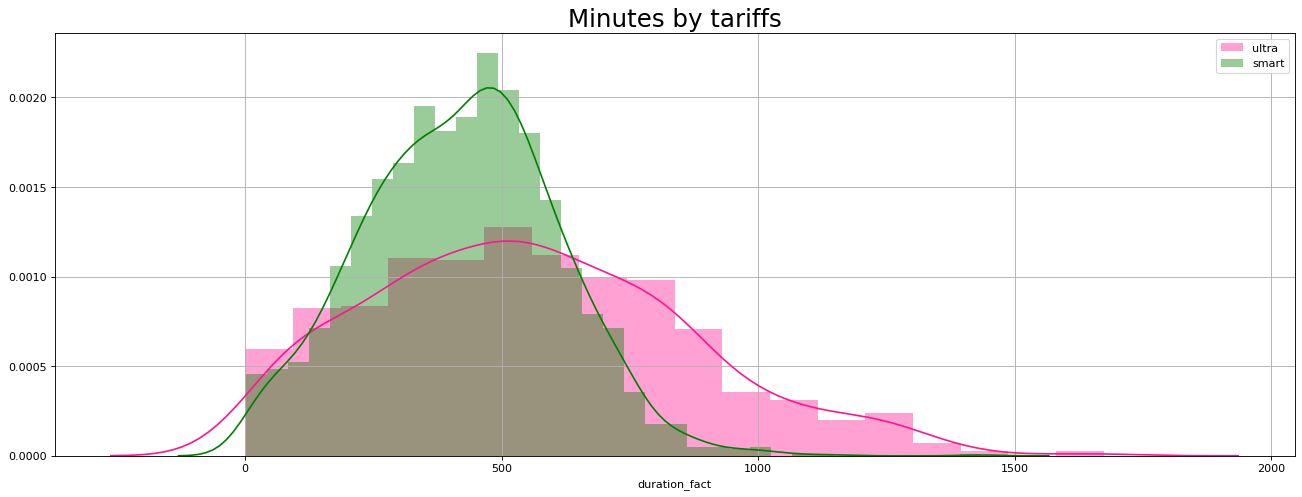

In [21]:
# Построим граффик распределния использованных минут по тарифам
plt.figure(figsize=(20,7), dpi= 80)
sns.distplot(total.loc[total['tariff_name'] == 'ultra', 'duration_fact'], color="deeppink", label="ultra")
sns.distplot(total.loc[total['tariff_name'] == 'smart','duration_fact'],color="g", label="smart")
plt.title('Minutes by tariffs', fontsize=22)
plt.legend()
plt.grid()
plt.show()

In [22]:
# Проанализируем среднее и стандартное отклонение
min = total.groupby('tariff_name')['duration_fact'].agg(['mean','var','std']).round().reset_index()
min['95%'] = min['mean']+min['std']*2
min

,tariff_name,mean,var,std,95%
0,smart,421.0,35141.0,187.0,795.0
1,ultra,555.0,96688.0,311.0,1177.0


Пользователи тарифа "Ультра" говорят в среднем больше, но и стандартное отклонение больше, чем у пользователей тарифа "Смарт". очевидно, что это связано с тем, что в тарифе "Ультра" больше бесплатных минут в пакете 3000 минут , в то время, как в тарифе "Смарт" только 500 минут.

Абоненты тарифа "Смарт" редко выходят за рамки своего бесплатного пакета. В то время как абоненты тарифа "Ультра" распределены шире и в целом не "выговаривают" свой пакет. В среднем пользователи обоих тарифов исользуют 420 и 550 минут в месяц, соответственно.

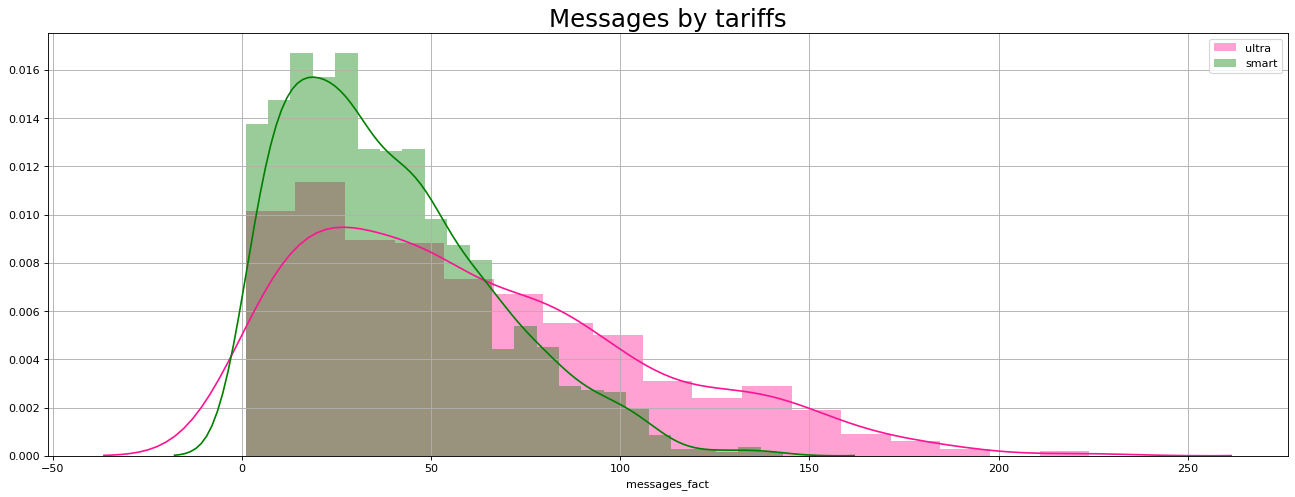

In [23]:
plt.figure(figsize=(20,7), dpi= 80)
sns.distplot(total.loc[total['tariff_name'] == 'ultra', 'messages_fact'], color="deeppink", label="ultra")
sns.distplot(total.loc[total['tariff_name'] == 'smart','messages_fact'], color="g", label="smart")
plt.title('Messages by tariffs', fontsize=22)
plt.legend()
plt.grid()
plt.show()

In [24]:
# Проанализируем среднее и стандартное отклоение
mes = total.groupby('tariff_name')['messages_fact'].agg(['mean','var','std']).round().reset_index()
mes['95%'] = mes['mean']+ mes['std']*2
mes

,tariff_name,mean,var,std,95%
0,smart,39.0,720.0,27.0,93.0
1,ultra,61.0,1975.0,44.0,149.0


Пользователи тарифа "Ультра" отправляют смс в среднем больше, но и стандартное отклонение больше, чем у пользователей тарифа "Смарт". очевидно, что это связано с тем, что в тарифе "Ультра" больше бесплатных сообщений в пакете (1000) , в то время, как в тарифе "Смарт" только 50 сообщений.

абоненты тарифа "Ультра" распределены шире и в целом не "выговаривают" свой пакет. В среднем пользователи обоих тарифов исользуют 39 и 61 сообщений в месяц, соотвественно.

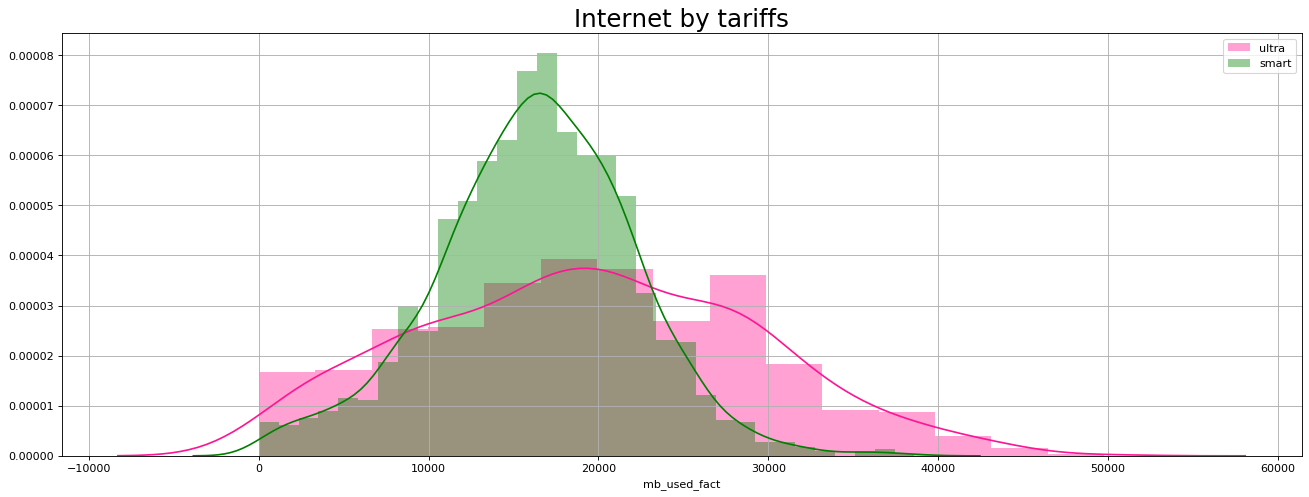

In [25]:
plt.figure(figsize=(20,7), dpi= 80)
sns.distplot(total.loc[total['tariff_name'] == 'ultra', 'mb_used_fact'], color="deeppink", label="ultra")
sns.distplot(total.loc[total['tariff_name'] == 'smart','mb_used_fact'],color="g", label="smart")
plt.title('Internet by tariffs', fontsize=22)
plt.legend()
plt.grid()
plt.show()

In [26]:
total.groupby('tariff_name')['mb_used_fact'].agg(['mean','var','std']).round().reset_index()

,tariff_name,mean,var,std
0,smart,16259.0,33761132.0,5810.0
1,ultra,19344.0,96979803.0,9848.0


Пользователи тарифа "Ультра" пользуются интернетом в среднем больше, но и стандартное отклонение больше, чем у пользователей тарифа "Смарт". очевидно, что это связано с тем, что в тарифе "Ультра" больше бесплатных мегабайт в пакете (30 ГБ) , в то время, как в тарифе "Смарт" только 16 ГБ.

абоненты тарифа "Ультра" распределены шире и в целом редко "выговаривают" свой пакет. В среднем пользователи обоих тарифов исользуют 16 и 19 ГБ в месяц, соотвественно.

**Вывод**

Пользователи тарифа "Смарт" явно более экономные клиенты, в связи с более ограниченными рамками тарифа, используют свзяь менее активно, но и чаще переплачивают за дополнительные минуты, сообщения и интернет. Стандартное отклонение показывает, что разброс между использованием связи абонентаами тарифа "Смарт" значительно меньше, так как ограниченный пакет заставляет их это делать.

Пользователи тарифа "Ультра" никогда не используют полностью минуты и сообщения, однако бывает превышение по скачанным мегабайтам. Стандартное отклонение показывает, что разброс между использованием связи абонентаами тарифа "Ультра" значительно выше, так как более широкие опции пакеты позволяют им это делать

## Проверка гипотез

### Выручка по тарифам

In [27]:
revenue.groupby('tariff_name')['total_rev'].agg(['mean','count','sum']).round().reset_index()

,tariff_name,mean,count,sum
0,smart,1294.0,2230,2886301.0
1,ultra,2071.0,986,2041950.0


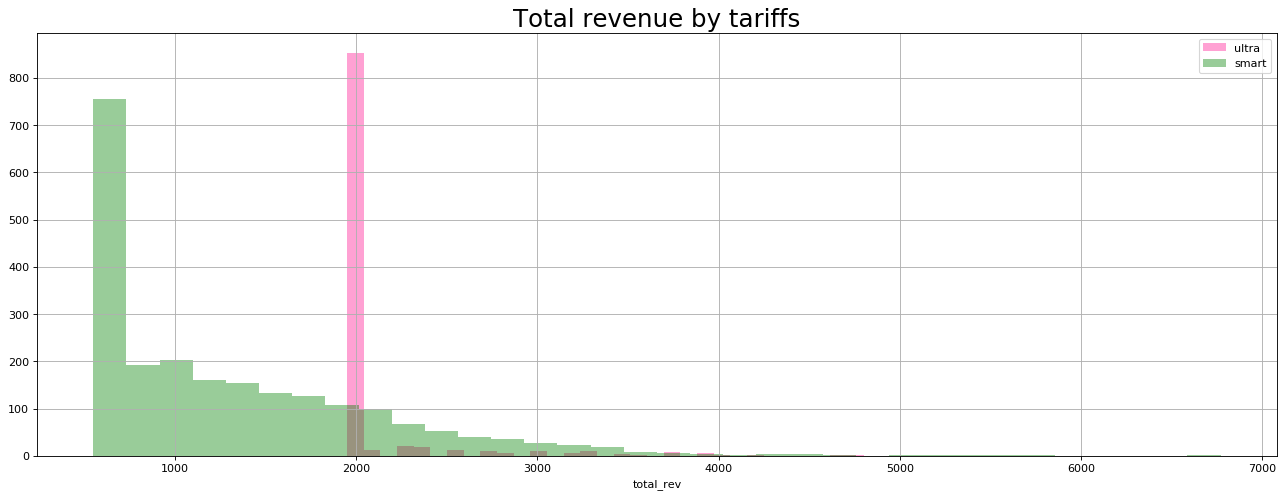

In [28]:
plt.figure(figsize=(20,7), dpi= 80)
sns.distplot(revenue.loc[revenue['tariff_name'] == 'ultra', 'total_rev'], color="deeppink", label="ultra", kde = False)
sns.distplot(revenue.loc[revenue['tariff_name'] == 'smart','total_rev'],color="g", label="smart", kde = False)
plt.title('Total revenue by tariffs', fontsize=22)
plt.legend()
plt.grid()
plt.show()

In [29]:
ultra = revenue.query('tariff_name == "ultra"')['total_rev']
smart = revenue.query('tariff_name == "smart"')['total_rev']

In [30]:
alpha = 0.05

In [31]:
results = st.ttest_ind(
    ultra, 
    smart)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.7023268870439853e-158
Отвергаем нулевую гипотезу


**Вывод**

P.value - очень низкий, это значит получить такую разницу между средними выручками абонентов разных тарифов случайно практически невозможно, отвергаем нулевую гипотезу и принимаем алтернативную - разница средних выручек пользователей тарифов «Ультра» и «Смарт» действительно различается

### Выручка по регионам

In [32]:
revenue.groupby('region')['total_rev'].agg(['mean','count','sum']).round().reset_index()

,region,mean,count,sum
0,Другой,1528.0,2605,3980709.0
1,Москва,1551.0,611,947542.0


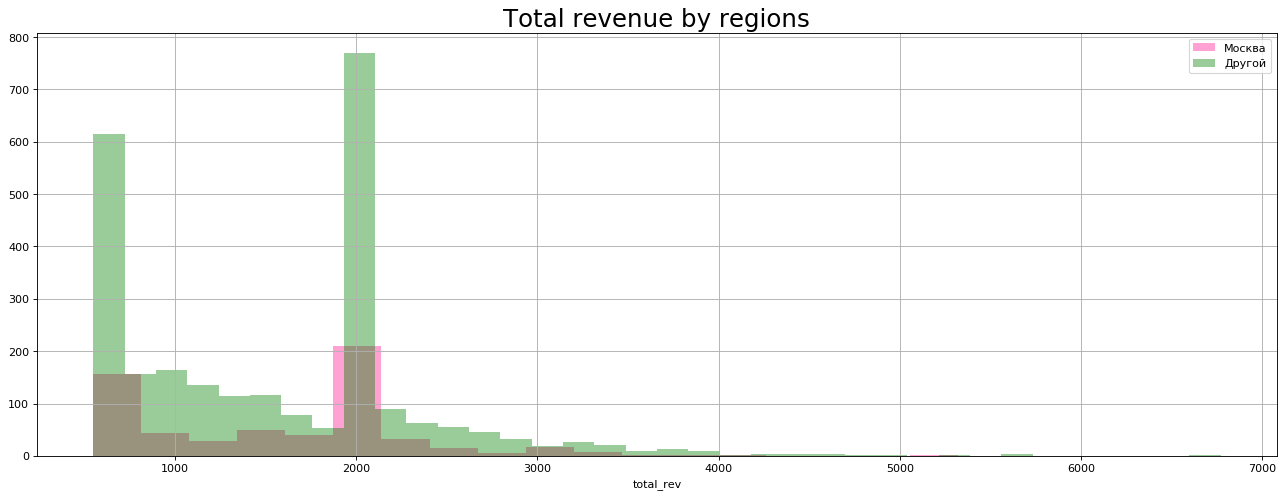

In [33]:
plt.figure(figsize=(20,7), dpi= 80)
sns.distplot(revenue.loc[revenue['region'] == 'Москва', 'total_rev'], color="deeppink", label="Москва", kde = False)
sns.distplot(revenue.loc[revenue['region'] == 'Другой','total_rev'],color="g", label="Другой", kde = False)
plt.title('Total revenue by regions', fontsize=22)
plt.legend()
plt.grid()
plt.show()

In [34]:
moscow = revenue.query('region == "Москва"')['total_rev']
other = revenue.query('region == "Другой"')['total_rev']

In [35]:
results = st.ttest_ind(
    moscow, 
    other)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5277299573181309
Не получилось отвергнуть нулевую гипотезу


**Вывод**

P.value - около 53%, это значит получить такую разницу между средними выручками абонентов разных регионов случайно более нашего, ранее установленного порога, принимаем нулевую гипотезу - разница средних выручек пользователей тарифов регионов Москва и все остальные - незначительна.

## Общие расчеты

In [36]:
revenue.pivot_table(index = 'tariff_name', columns = 'region', values = 'escape', aggfunc = 'sum').reset_index()

region,tariff_name,Другой,Москва
0,smart,87,25
1,ultra,61,16


In [37]:
density = revenue.groupby('tariff_name')[['duration_fact','messages_fact','mb_used_fact','total_rev']].sum().reset_index()
density['min_return'] = density['total_rev'] / density['duration_fact']
density['mes_return'] = density['total_rev'] / density['messages_fact']
density['int_return'] = density['total_rev'] / density['mb_used_fact']
density[['tariff_name','min_return','mes_return','int_return']].round(2)

,tariff_name,min_return,mes_return,int_return
0,smart,3.10,38.79,0.08
1,ultra,3.94,42.00,0.11


## Общий вывод

**В среднем наши клиенты используют за месяц:**

**Тариф "Смарт"**
421 минуту
34 сообщения
более 16 Гб
Средняя выручка 1328 руб.
Процент пользователей - 70%

**Тариф "Ультра"**

555 минут
52 сообщения
более 19Гб
Средняя выручка 2086 руб.
Процент пользователей - 30%

**Средняя выручка пользователей тарифов «Ультра» и «Смарт» различается**

Применили метод для гипотезы о равенстве средних двух генеральных совокупностей, так как мы сравнивали средние двух совокупностей по разным тарифам.

Нулевая гипотеза: Средняя выручка по тарифам разливается

Альфа: выбираем альфу (Зададим порог допустимой ошибки в 5%) - равную 5%. Если вероятность получения разности в средней выручке больше, чем этот коэффициент, то мы бы отвергли гипотезу, что средняя выручка пользователей тарифов «Ультра» и «Смарт» различается.

Полученное значение p-value говорит о том, что средняя выручка абонентов разных тарифов отличается и с вероятностью в почти 0% такое различие можно получить случайно. Это явно слишком маленькая вероятность, чтобы делать вывод о равенстве выручек по тарифам.

**Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов**

Применили метод для гипотезы о равенстве средних двух генеральных совокупностей, так как мы сравнивали средние двух совокупностей по разным тарифам.

Нулевая гипотеза: Средняя выручка пользователей из Москвы отличается от пользователей из других регионов.

Альфа: выбираем альфу (Зададим порог допустимой ошибки в 5%) - равную 5%. Если вероятность получения разности в средней выручке больше, чем этот коэффициент, то мы бы отвергли нулевую гипотезу.

Полученное значение p-value говорит о том, что хотя средняя выручка абонентов из разных городов неодинакова, с вероятностью в 38% такое или большее различие можно получить случайно. Это явно слишком большая вероятность, чтобы делать вывод о значимом различии между средней вырочкой.

**Какой тариф лучше**
Пользователи из регионов отдают предпочтение тарифу Смарт 1844 против 761 пользователей тарифа Ультра, в то время, как разница между количеством пользователей тарифов в Москве менее значительна 386 против 225 соответственно.

Анализ отказов от наших услуг не показал значительной разницы между тарифами.

Тариф смарт приносит нам больше денег 2,8 млн против 2 млн тарифа Ультра за 2018 год, очевидно, что это связано с количеством абонентов

Рентабельность на 1 единицу любой услуги выше в тарифе Ультра

**Итог:**
-Тариф Смарт приносит нам больше денег в абсолюте, но это за счет количества абонентов, в то время, как тариф Ультра - более рентабельный.

**Рекомендации по тарифам:**
Есть смысл обратить внимание на то, что клиентов Ультры значительно меньше, чем тарифа Смарт. Абоненты тарифа явно не используют все свои бесплатные минуты и сообщения, есть смысл их уменьшить:

количество бесплатных минут до 1200 (так как 95% абонентам хватает 1177 минут)
количество бесплатных сообщений до 150 (так как 95% абонентам хватает 149 сообщений)
За счет этого снизить цену на абонентскую плату, таким образом мы можем привлечь новых клиентов.
